In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score , log_loss, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RandomizedLasso
from sklearn.tree import DecisionTreeRegressor

#import sys
#sys.path.insert(0,"/usr/local/lib/python2.7/dist-packages")
#import pyflux

In [33]:
print(sys.path)

['/usr/local/lib/python2.7/dist-packages', '/home/reda/pyflux-0.4.13/', '/home/reda/pycast/pycast/', '', '/home/reda/xgboost/python-package', '/home/reda/anaconda3/lib/python35.zip', '/home/reda/anaconda3/lib/python3.5', '/home/reda/anaconda3/lib/python3.5/plat-linux', '/home/reda/anaconda3/lib/python3.5/lib-dynload', '/home/reda/anaconda3/lib/python3.5/site-packages', '/home/reda/anaconda3/lib/python3.5/site-packages/Sphinx-1.4.6-py3.5.egg', '/home/reda/anaconda3/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '/home/reda/anaconda3/lib/python3.5/site-packages/IPython/extensions', '/home/reda/.ipython']


In [2]:
sigma = pd.read_hdf("./data/train.h5")

In [46]:
sigma_train = sigma[sigma["timestamp"].isin(sigma["timestamp"].unique()[:913])]
sigma_test  = sigma[sigma["timestamp"].isin(sigma["timestamp"].unique()[913:])]

In [47]:
Id=11
sigma_single_train=sigma_train[sigma_train.id==Id]
sigma_single_test=sigma_test[sigma_test.id==Id]

ts_train=sigma_single_train.y.values
time_train=sigma_single_train.timestamp.values
ts_test=sigma_single_test.y.values
time_test=sigma_single_test.timestamp.values

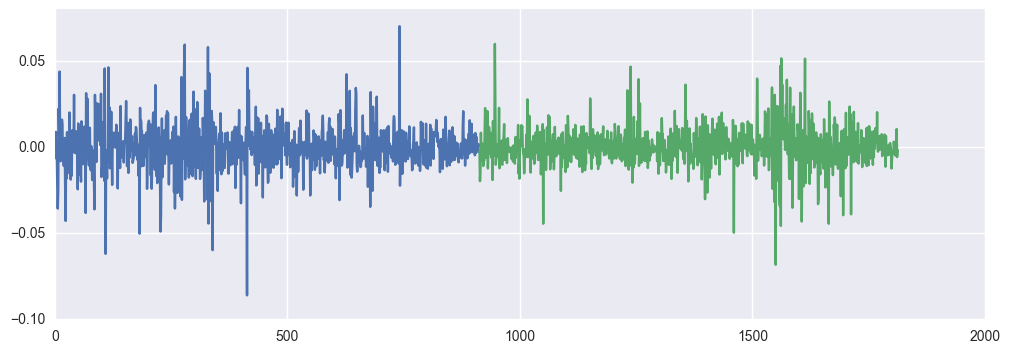

In [28]:
plt.figure(figsize=(12,4))
plt.plot(time_train,ts_train)
plt.plot(time_test,ts_test)
#plt.plot(time_test,y_pred_model)

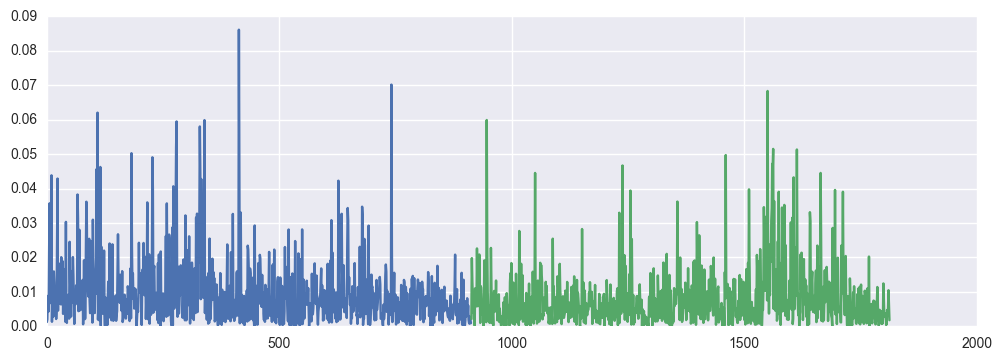

In [48]:
plt.figure(figsize=(12,4))
plt.plot(time_train,np.absolute(ts_train))
plt.plot(time_test,np.absolute(ts_test))
#plt.plot(time_test,y_pred_model)

#### Predicting using the features

In [25]:
linear=LinearRegression().fit(sigma_single_train.loc[:,["technical_20","technical_30"]],sigma_single_train.loc[:,"y"])
y_pred_model=linear.predict(sigma_single_test.loc[:,["technical_20","technical_30"]])

#### Predicting using Winter Holt forecasting method

In [ ]:
time_series=TimeSeries.from_twodim_list(datalist=[[t,s] for t,s in zip(time_train,ts_train)])

In [ ]:
holt=HoltMethod(smoothingFactor=0.02,trendSmoothingFactor=0.01,valuesToForecast=1)
gridSearch = gridsearch.GridSearch(SMAPE.SymmetricMeanAbsolutePercentageError)
optimal_forecasting, error, optimal_params = gridSearch.optimize(time_series, [holt])

In [ ]:
predicted = optimal_forecasting.execute(time_series).to_twodim_list()

## Clustering Ids using cumulative returns

In [11]:
_=sigma.fillna(sigma.median(axis=0),axis=0,inplace=True)

In [55]:
len(sigma.id.unique())

1424

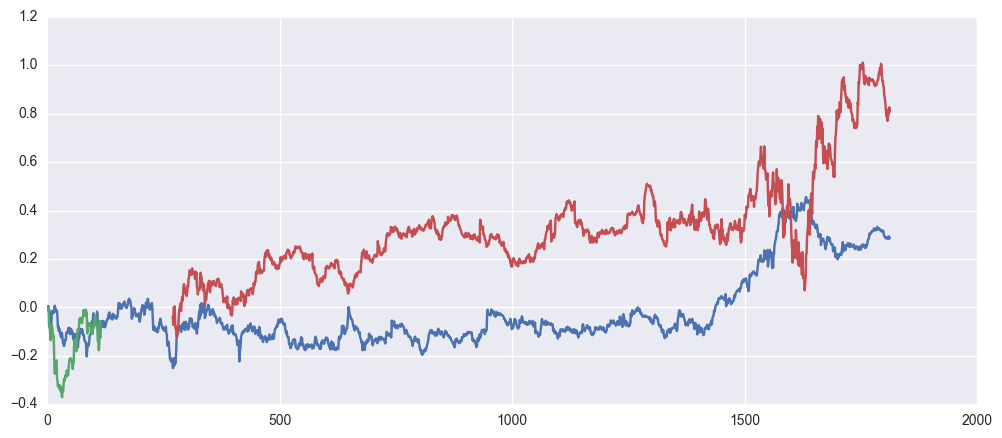

In [40]:
plt.figure(figsize=(12,5))
plt.plot(sigma[sigma.id==11].timestamp,np.cumsum(sigma[sigma.id==11].y))
plt.plot(sigma[sigma.id==10].timestamp,np.cumsum(sigma[sigma.id==10].y))
plt.plot(sigma[sigma.id==7].timestamp,np.cumsum(sigma[sigma.id==7].y))

In [12]:
def reach_1812(series):
    if 1812 in series.values:
        return(True)
    else:
        return(False)

In [13]:
ids_reach_end=sigma.groupby("id")["timestamp"].agg(reach_1812)
ids_reach_end=ids_reach_end[ids_reach_end==True].index.values

In [14]:
print("There is %d ids, from which %d reach the last timestamp"%(len(sigma.id.unique()),len(ids_reach_end)))

There is 1424 ids, from which 1086 reach the last timestamp


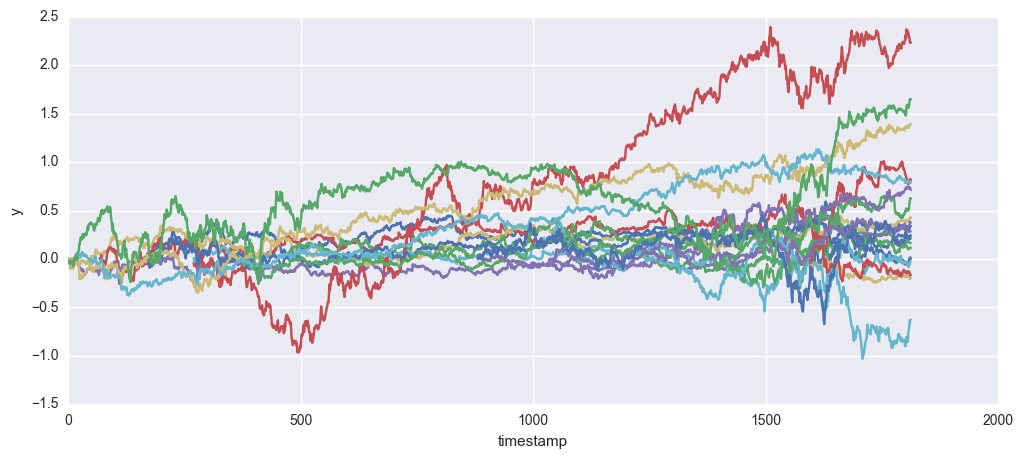

In [60]:
plt.figure(figsize=(12,5))
for Id in ids_reach_end[:20]:
    plt.plot(sigma[sigma.id==Id].timestamp,sigma[sigma.id==Id].y.cumsum())
plt.xlabel('timestamp')
plt.ylabel('y')

In [15]:
sigma_reach=sigma[sigma.id.isin(ids_reach_end)]

In [16]:
sigma_reach=sigma_reach[['id', 'timestamp', 'y']].pivot_table(values='y',
                                     index='timestamp',columns='id')

In [17]:
sigma_reach_sum=sigma_reach.cumsum()

In [20]:
sigma_reach_sum.head(1)

id,0,6,7,11,12,13,14,15,16,17,...,2142,2145,2146,2148,2149,2150,2151,2154,2156,2158
timestamp,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,-0.00124,-0.02218,NaN,NaN,NaN,NaN,NaN,...,0.234638,NaN,0.287898,0.272873,0.256538,NaN,NaN,0.240386,0.228664,NaN


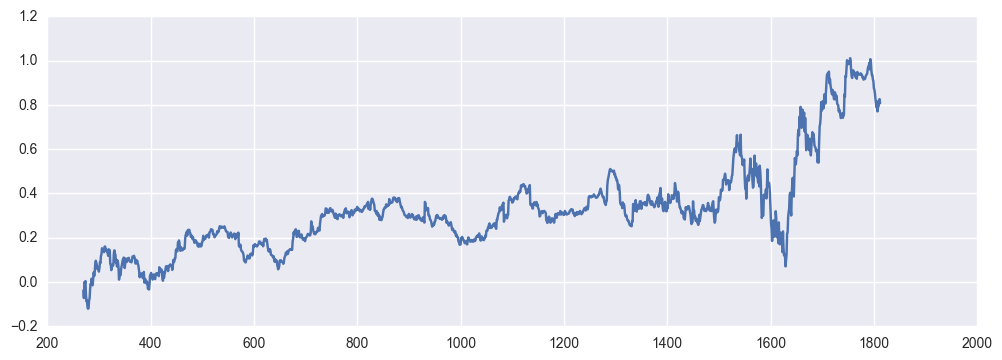

In [27]:
plt.figure(figsize=(12,4))
plt.plot(sigma_reach_sum.index,sigma_reach_sum.loc[:,7])

In [18]:
means = sigma_reach_sum.mean(axis=1)
sigma_reach_sum_nomean = sigma_reach_sum.subtract(means.values,axis="rows")

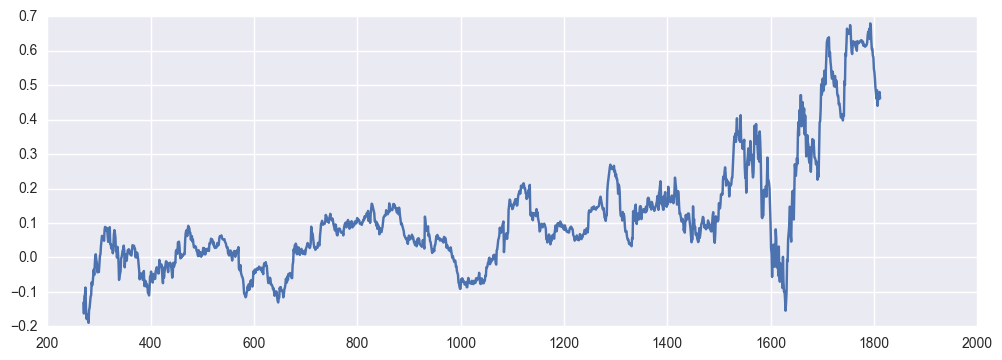

In [31]:
plt.figure(figsize=(12,4))
plt.plot(sigma_reach_sum_nomean.index,sigma_reach_sum_nomean.loc[:,7])

In [19]:
corr_ids=sigma_reach_sum_nomean.corr()

In [20]:
corr_ids.head()

id,0,6,7,11,12,13,14,15,16,17,...,2142,2145,2146,2148,2149,2150,2151,2154,2156,2158
id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.358470,-0.203371,0.234112,0.003882,0.156718,0.329061,-0.067436,-0.079270,0.020326,...,-0.036560,-0.088232,0.018241,0.173250,-0.166623,0.116007,0.345408,-0.084136,0.176764,0.433822
6,0.358470,1.000000,0.312355,0.559103,0.403652,-0.565105,0.182786,0.561113,0.161276,0.322442,...,0.183381,0.187376,-0.083204,0.608547,0.383261,0.604795,-0.395042,0.352985,-0.465487,-0.145055
7,-0.203371,0.312355,1.000000,0.451422,0.253602,-0.794810,-0.433677,0.355267,0.667041,0.534835,...,0.526962,0.478635,-0.629752,0.083394,0.452938,0.618323,-0.585328,0.649759,-0.737920,0.219493
11,0.234112,0.559103,0.451422,1.000000,0.494327,-0.526459,0.225459,0.043589,0.401505,0.746232,...,0.360743,0.568968,0.071164,0.497190,0.443006,0.567409,-0.457807,0.318794,-0.418360,-0.207393
12,0.003882,0.403652,0.253602,0.494327,1.000000,-0.205428,0.062682,0.153360,0.154861,0.339841,...,0.102385,0.206122,0.062466,0.157507,0.013817,0.202473,-0.343053,-0.005143,-0.029383,-0.279982


(array([  2344.,     86.,    666.,   1498.,   2850.,   4074.,   5118.,
          6472.,   7546.,   8664.,   9424.,  10188.,  10636.,  11628.,
         11924.,  11982.,  12622.,  12622.,  12914.,  13248.,  13032.,
         13360.,  13376.,  13556.,  13272.,  13558.,  13560.,  13866.,
         13706.,  13746.,  13828.,  14162.,  13834.,  14086.,  13848.,
         13950.,  13752.,  13750.,  14002.,  14164.,  14142.,  14050.,
         14060.,  14046.,  14130.,  13910.,  14168.,  14048.,  13850.,
         14094.,  14124.,  13934.,  13940.,  14084.,  13728.,  14024.,
         13980.,  14134.,  13874.,  14280.,  13858.,  13960.,  14130.,
         14324.,  13804.,  14088.,  13992.,  14332.,  14366.,  14108.,
         14330.,  14382.,  14362.,  14112.,  14238.,  14242.,  14594.,
         14508.,  14378.,  14628.,  14074.,  14050.,  14170.,  13792.,
         13480.,  13482.,  12916.,  12094.,  11786.,  10714.,   9894.,
          9386.,   8360.,   7148.,   6014.,   4258.,   2710.,   1342.,
      

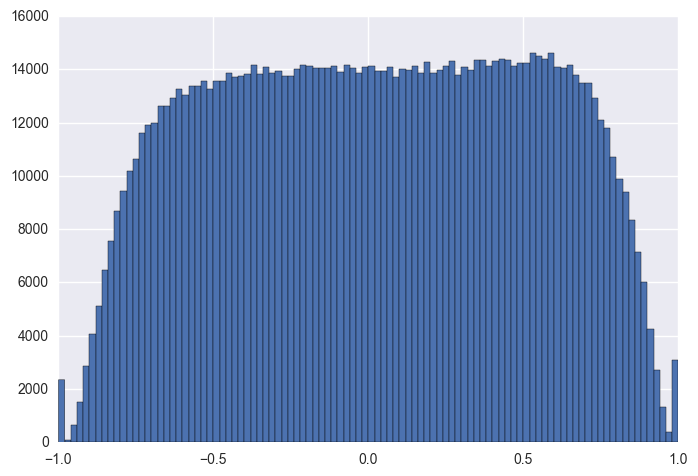

In [38]:
plt.hist(corr_ids.values.flatten(),bins=100)

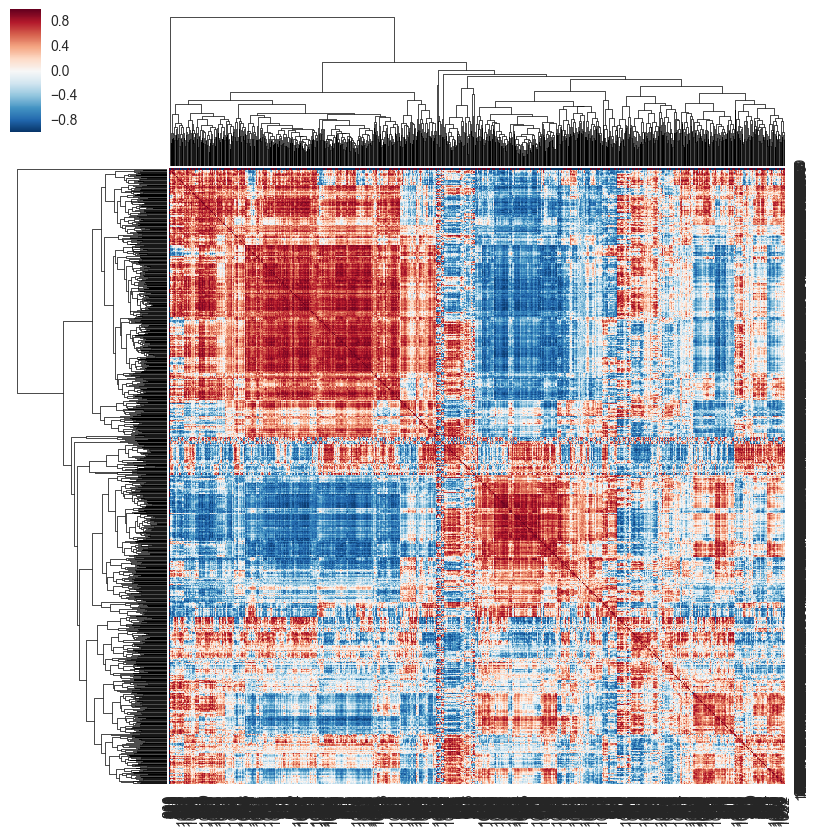

In [39]:
g = sns.clustermap(corr_ids.values,metric="euclidean",method="average")

In [21]:
corr_ids_mean = np.mean(np.abs(corr_ids),axis = 1)

In [44]:
MIN_CORR = 0.45
index = corr_ids_mean > MIN_CORR
corr_ids_cut = corr_ids.loc[index,index]

(array([ 1120.,    80.,   586.,  1266.,  2342.,  3240.,  3916.,  4652.,
         5220.,  5490.,  5588.,  5638.,  5270.,  5324.,  4900.,  4296.,
         4274.,  3828.,  3460.,  3230.,  2824.,  2664.,  2352.,  2104.,
         1952.,  1804.,  1542.,  1532.,  1292.,  1192.,  1116.,  1068.,
          920.,   910.,   818.,   784.,   742.,   684.,   654.,   680.,
          716.,   630.,   614.,   654.,   586.,   570.,   616.,   622.,
          536.,   576.,   606.,   554.,   576.,   586.,   608.,   640.,
          584.,   636.,   618.,   710.,   696.,   766.,   760.,   774.,
          796.,   890.,   942.,  1020.,  1128.,  1276.,  1294.,  1576.,
         1510.,  1770.,  1898.,  2104.,  2396.,  2652.,  2912.,  3322.,
         3472.,  3924.,  4434.,  4758.,  5054.,  5678.,  5896.,  6082.,
         6424.,  6232.,  6414.,  6332.,  6292.,  5542.,  4854.,  3578.,
         2336.,  1208.,   360.,  1312.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -

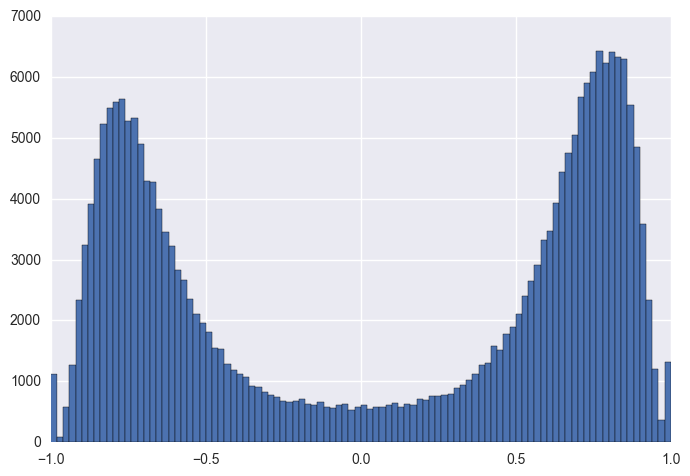

In [45]:
plt.hist(corr_ids_cut.values.flatten(),bins=100)

In [46]:
len(corr_ids_cut.index)

484

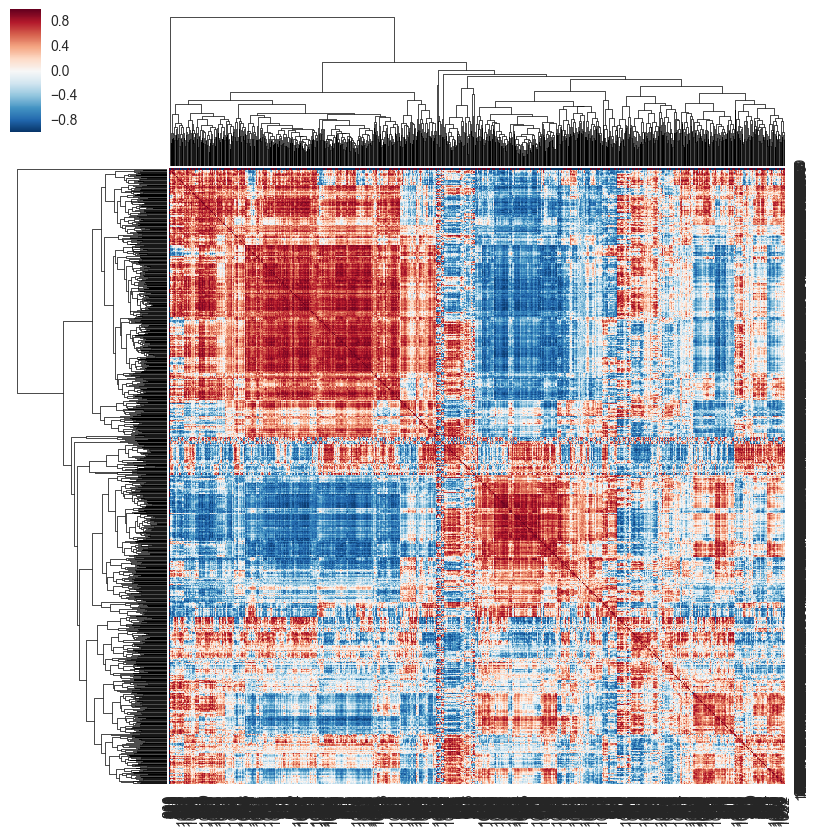

In [47]:
g = sns.clustermap(corr_ids.values,metric="euclidean",method="average")

In [51]:
a =sigma.loc[:, ["id","timestamp","y"] ][:5]
a

,id,timestamp,y
0,10,0,-0.011753
1,11,0,-0.001240
2,12,0,-0.020940
3,25,0,-0.015959
4,26,0,-0.007338


In [64]:
 pd.DataFrame([[10,1,0.01]], columns=["id","timestamp","y"])

,id,timestamp,y
0,10,1,0.01


In [66]:
a.append( pd.DataFrame([[10,1,0.01]], columns=["id","timestamp","y"]),ignore_index=True)

,id,timestamp,y
0,10,0,-0.011753
1,11,0,-0.001240
2,12,0,-0.020940
3,25,0,-0.015959
4,26,0,-0.007338
5,10,1,0.010000


In [119]:
a=dict(sigma.groupby(["id"])["y"].apply(lambda x: x.values[:5].mean()))

In [120]:
a

{0: 5.4241343605099246e-05,
 6: 0.0018906064797192812,
 7: 0.00085340143414214253,
 10: -0.015675585716962814,
 11: -0.0010727585759013891,
 12: -0.0034802004229277372,
 13: -0.0011333391303196549,
 14: -0.028890352696180344,
 15: 0.016004670411348343,
 16: -0.0027685821987688541,
 17: 0.00048592500388622284,
 18: -0.0074630128219723701,
 19: 0.0025677862577140331,
 20: -0.0058566033840179443,
 22: -0.0084968311712145805,
 23: -0.001283922465518117,
 24: 0.00088353798491880298,
 25: -0.01501082070171833,
 26: -0.0059730545617640018,
 27: 0.016369352117180824,
 30: 0.0068461028859019279,
 31: -0.0094962967559695244,
 32: -0.026696836575865746,
 33: 0.0058022085577249527,
 38: -0.0022222313564270735,
 39: -0.0030000389087945223,
 40: -0.00063653325196355581,
 41: -0.0045682121999561787,
 43: 0.0015984438359737396,
 44: 0.0035748512018471956,
 46: -0.0046739112585783005,
 47: -0.013795574195683002,
 48: 0.007501739077270031,
 49: 0.0020118250977247953,
 52: 0.0043843770399689674,
 54: 0.0

In [106]:
a[0:3]

id
0    [-0.00710843, 0.00194992, 0.0177242, 0.0129345...
6    [0.00963646, 0.00700805, -0.00641123, 0.001777...
7    [-0.0384104, -0.0341414, 0.0718747, -0.0064520...
Name: y, dtype: object

In [94]:
a[0][:5]

array([-0.00710843,  0.00194992,  0.01772425,  0.01293446, -0.02522899], dtype=float32)

In [85]:
a.get_group(11).reset_index(drop=True)

,timestamp,y
0,0,-0.001240
1,1,-0.002024
2,2,0.008788
3,3,-0.006551
4,4,-0.004336
5,5,-0.022718
6,6,-0.035710
7,7,-0.024840
8,8,0.022319
9,9,0.006719
